<a href="https://colab.research.google.com/github/gus474/Analysis-of-Systolic-Blood-Pressure-Variance/blob/main/Predicting_Cherries_via_NIR_Spectroscopy_Measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://www.goodfruit.com/wp-content/uploads/spectrometerBC-10969tj-1.jpg" height=400></center>


To start chipping away at this analytical challenge, I wrote code that enables me to iteratively search through all of these bands and test their predictive capacity using correlation analysis, linear regression, and k-fold cross validation.
Let me start by loading my dataset...



#### Loading the `cherry_data_spectral.csv` as a Pandas DataFrame and assigning it to the variable name `df_cherry_spectral`. Using `fruit_id` for the `index_col` argument, I printed the dataframe.


In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
df_cherry_spectral = pd.read_csv('/content/drive/MyDrive/EBSTUT/Copy of Copy of cherry_data_spectral.csv', index_col = 0)
df_cherry_spectral

,variety,dry_matter_ratio,abs_351,abs_354,abs_357,abs_360,abs_363,abs_366,abs_369,abs_372,abs_375,abs_378,abs_381,abs_384,abs_387,abs_390,abs_393,abs_396,abs_399,abs_402,abs_405,abs_408,abs_411,abs_414,abs_417,abs_420,abs_423,abs_426,abs_429,abs_432,abs_435,abs_438,abs_441,abs_444,abs_447,abs_450,abs_453,abs_456,abs_459,abs_462,...,abs_1020,abs_1023,abs_1026,abs_1029,abs_1032,abs_1035,abs_1038,abs_1041,abs_1044,abs_1047,abs_1050,abs_1053,abs_1056,abs_1059,abs_1062,abs_1065,abs_1068,abs_1071,abs_1074,abs_1077,abs_1080,abs_1083,abs_1086,abs_1089,abs_1092,abs_1095,abs_1098,abs_1101,abs_1104,abs_1107,abs_1110,abs_1113,abs_1116,abs_1119,abs_1122,abs_1125,abs_1128,abs_1131,abs_1134,abs_1137
fruit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Brooks,0.185236,-0.43839,-0.36569,-0.33069,-0.22882,-0.12428,-0.10428,-0.085935,-0.170650,-0.097317,-0.035624,0.020991,0.057527,0.116710,0.188050,0.25226,0.35199,0.42152,0.52341,0.59509,0.67883,0.72119,0.75902,0.79087,0.80594,0.81244,0.81812,0.82667,0.83092,0.83358,0.83873,0.84276,0.84484,0.84599,0.84684,0.84708,0.84791,0.85341,0.84803,...,-0.27426,-0.29123,-0.30759,-0.32394,-0.34064,-0.35648,-0.37121,-0.38548,-0.39930,-0.41081,-0.42192,-0.43146,-0.44135,-0.44879,-0.45436,-0.45811,-0.46215,-0.46402,-0.46610,-0.46629,-0.46376,-0.46189,-0.45860,-0.45158,-0.44780,-0.44298,-0.43410,-0.42255,-0.41498,-0.40569,-0.39626,-0.38224,-0.37190,-0.34610,-0.31830,-0.28441,-0.24585,-0.185510,-0.099923,0.014430
1,Brooks,0.174644,-0.42486,-0.35590,-0.33398,-0.35690,-0.31999,-0.26151,-0.207480,-0.143430,-0.157120,-0.097892,-0.052814,0.005556,0.060624,0.121770,0.20920,0.29833,0.37163,0.47103,0.56769,0.63703,0.69615,0.73817,0.76104,0.77611,0.79286,0.79862,0.79708,0.80210,0.80993,0.81133,0.81395,0.81990,0.82379,0.82393,0.82547,0.82065,0.82498,0.82322,...,-0.22493,-0.24234,-0.25973,-0.27701,-0.29326,-0.30895,-0.32525,-0.33902,-0.35372,-0.36550,-0.37843,-0.38838,-0.39657,-0.40438,-0.41118,-0.41566,-0.42006,-0.42225,-0.42307,-0.42377,-0.42294,-0.41914,-0.41496,-0.41149,-0.40446,-0.39599,-0.39063,-0.38184,-0.37586,-0.36236,-0.34851,-0.33908,-0.31921,-0.30434,-0.27448,-0.23552,-0.18986,-0.123510,-0.036958,0.064054
2,Brooks,0.175098,-0.49384,-0.42320,-0.36296,-0.33995,-0.33593,-0.30913,-0.220050,-0.212840,-0.138560,-0.142610,-0.081566,-0.043525,0.018692,0.097575,0.16446,0.28022,0.37531,0.46320,0.54537,0.62576,0.68848,0.73456,0.76665,0.78530,0.79298,0.79920,0.80652,0.81966,0.81974,0.81885,0.82368,0.83008,0.83320,0.83446,0.83817,0.83678,0.83916,0.83586,...,-0.22171,-0.23806,-0.25446,-0.27059,-0.28628,-0.30151,-0.31596,-0.32887,-0.34194,-0.35407,-0.36366,-0.37299,-0.38261,-0.38940,-0.39533,-0.39826,-0.40199,-0.40568,-0.40644,-0.40488,-0.40417,-0.40350,-0.40028,-0.39455,-0.38833,-0.38436,-0.37623,-0.36679,-0.36167,-0.35180,-0.33987,-0.32834,-0.31252,-0.29438,-0.26643,-0.22875,-0.19289,-0.133710,-0.061572,0.038103
3,Brooks,0.145359,-0.45210,-0.36978,-0.37076,-0.38178,-0.32920,-0.28253,-0.184360,-0.182010,-0.098632,-0.139020,-0.039727,0.013986,0.064212,0.129260,0.19738,0.32807,0.37042,0.47250,0.56689,0.64297,0.71140,0.75538,0.77873,0.79401,0.80527,0.81011,0.82419,0.82363,0.82790,0.82915,0.83158,0.83588,0.83730,0.83621,0.84035,0.84414,0.84579,0.84735,...,-0.24444,-0.26124,-0.27782,-0.29442,-0.31079,-0.32647,-0.34183,-0.35532,-0.36896,-0.38058,-0.39220,-0.40305,-0.41064,-0.41892,-0.42352,-0.42899,-0.43301,-0.43607,-0.43627,-0.43759,-0.43652,-0.43314,-0.43020,-0.42404,-0.41863,-0.40897,-0.40811,-0.39537,-0.38848,-0.36945,-0.36997,-0.34803,-0.34152,-0.30710,-0.29244,-0.25262,-0.21028,-0.138230,-0.063032,0.074145
4,Brooks,0.180789,-0.49566,-0.40835,-0.28616,-0.21952,-0.22667,-0.21431,-0.216670,-0.112890,-0.014164,-0.015699,0.006115,0.025398,0.095992,0.194980,0.27296,0.37038,0.44856,0.55320,0.62740,0.69436,0.74783,0.78470,0.80958,0.82642,0.83518,0.83774,0.83818,0.84938,0.85172,0.85499,0.85860,0.85989,0.86077,0.86363,0.86649,0.86699,0.86799,0.86621,...,-0.25687,-0.27392,-0.29062,-0.30682,-0.32289

#### Finding the strongest spectral correlate, based on Pearson's r value, with `dry_matter_ratio`. 
- Used a Pandas correlation matrix
- Sorted the correlation_matrix by `dry_matter_ratio` so that it is easy to determine the strongest correlate
- Used the absolute value method,  `.abs()`, as the strongest correlate can be positive or negative.

In [12]:
corr_matrix = df_cherry_spectral.corr().abs()

corr_matrix = corr_matrix.sort_values(by=['dry_matter_ratio'], ascending=False)
corr_matrix #The strongest correlation matrix is abs_870, with a Pearson's r values of 0.529490.

,dry_matter_ratio,abs_351,abs_354,abs_357,abs_360,abs_363,abs_366,abs_369,abs_372,abs_375,abs_378,abs_381,abs_384,abs_387,abs_390,abs_393,abs_396,abs_399,abs_402,abs_405,abs_408,abs_411,abs_414,abs_417,abs_420,abs_423,abs_426,abs_429,abs_432,abs_435,abs_438,abs_441,abs_444,abs_447,abs_450,abs_453,abs_456,abs_459,abs_462,abs_465,...,abs_1020,abs_1023,abs_1026,abs_1029,abs_1032,abs_1035,abs_1038,abs_1041,abs_1044,abs_1047,abs_1050,abs_1053,abs_1056,abs_1059,abs_1062,abs_1065,abs_1068,abs_1071,abs_1074,abs_1077,abs_1080,abs_1083,abs_1086,abs_1089,abs_1092,abs_1095,abs_1098,abs_1101,abs_1104,abs_1107,abs_1110,abs_1113,abs_1116,abs_1119,abs_1122,abs_1125,abs_1128,abs_1131,abs_1134,abs_1137
dry_matter_ratio,1.000000,0.100805,0.116577,0.123440,0.119826,0.138924,0.071253,0.125241,0.008966,0.055943,0.011432,0.017046,0.011765,0.035731,0.049202,0.066282,0.052479,0.071668,0.071392,0.084622,0.084070,0.088851,0.088130,0.086115,0.086975,0.087114,0.091054,0.090103,0.091721,0.085694,0.085726,0.083501,0.083510,0.085781,0.086826,0.086155,0.083079,0.081125,0.079356,0.078952,...,0.352199,0.360737,0.369421,0.378474,0.387757,0.396621,0.405009,0.413138,0.420598,0.427237,0.433731,0.440269,0.444299,0.448835,0.451417,0.453343,0.455541,0.457086,0.457208,0.456611,0.452909,0.448324,0.445636,0.442060,0.439155,0.433165,0.425683,0.417499,0.408250,0.402413,0.396039,0.384429,0.377564,0.357851,0.338698,0.320608,0.301918,0.256847,0.198637,0.139799
abs_870,0.529490,0.256086,0.277396,0.267707,0.225632,0.236076,0.141107,0.231788,0.083663,0.136416,0.002339,0.028685,0.100198,0.138077,0.153263,0.196062,0.191711,0.254742,0.262125,0.292290,0.286904,0.298694,0.301928,0.308415,0.323749,0.329004,0.332870,0.335390,0.341343,0.341367,0.343658,0.343828,0.344989,0.346660,0.347252,0.348129,0.347245,0.347749,0.346769,0.346438,...,0.862507,0.870092,0.877582,0.885090,0.892589,0.899594,0.906024,0.912482,0.918035,0.923372,0.927646,0.931927,0.935315,0.938381,0.940247,0.942322,0.943273,0.943981,0.944173,0.944455,0.943378,0.941287,0.939445,0.936774,0.934290,0.930322,0.926634,0.920602,0.915881,0.908573,0.902063,0.894022,0.890057,0.874432,0.864925,0.846080,0.823900,0.772967,0.707662,0.609890
abs_873,0.529392,0.256932,0.278279,0.268788,0.227113,0.237797,0.142842,0.233155,0.085713,0.138754,0.000128,0.026147,0.097621,0.135552,0.150757,0.193504,0.189278,0.252292,0.259711,0.289892,0.284551,0.296363,0.299622,0.306143,0.321507,0.326794,0.330697,0.333219,0.339232,0.339285,0.341613,0.341808,0.342988,0.344667,0.345264,0.346165,0.345311,0.345837,0.344898,0.344598,...,0.865856,0.873376,0.880799,0.888236,0.895664,0.902600,0.908963,0.915345,0.920836,0.926101,0.930329,0.934561,0.937910,0.940930,0.942777,0.944820,0.945779,0.946484,0.946688,0.946971,0.945920,0.943875,0.942075,0.939471,0.937019,0.933133,0.929473,0.923561,0.918881,0.911709,0.905245,0.897334,0.893323,0.877878,0.868314,0.849544,0.827216,0.776086,0.710271,0.611907
abs_867,0.529381,0.255283,0.276525,0.266610,0.224141,0.234321,0.139356,0.230405,0.081618,0.134039,0.004877,0.031326,0.102882,0.140700,0.155860,0.198713,0.194254,0.257296,0.264637,0.294801,0.289372,0.301139,0.304343,0.310796,0.326099,0.331324,0.335155,0.337671,0.343568,0.343565,0.345819,0.345966,0.347109,0.348771,0.349359,0.350211,0.349296,0.349783,0.348766,0.348405,...,0.859232,0.866875,0.874427,0.881999,0.889564,0.896633,0.903124,0.909651,0.915260,0.920665,0.924980,0.929304,0.932728,0.935836,0.937719,0.939822,0.940763,0.941471,0.941652,0.941930,0.940828,0.938693,0.936809,0.934073,0.931558,0.927509,0.923797,0.917650,0.912890,0.905448,0.898901,0.890728,0.886812,0.871015,0.861573,0.842665,0.820644,0.769925,0.705150,0.607992
abs_876,0.529125,0.257796,0.279173,0.269892,0.228633,0.239533,0.144577,0.234562,0.087773,0.141096,0.002554,0.023674,0.095102,0.133084,0.148320,0.191025,0.186938,0.249939,0.257397,0.287605,0.282304,0.294136,0.297425,0.303978,0.319367,0.324685,0.328623,0.331150,0.337224,0.337309,0.339675,0.339893,0.341093,0.342783,0.343385,0.344313,0.343488,0.344036,0.343139,0.342872,.

#### Calculate a correlation matrix for each cherry variety
- For the iterable I used `df_cherry_spectral['variety'].unique()` to create an array (shape = `(7,)`) called `varieties` that has an element corresponding with each unique cherry variety 
- I looped through `variety` to extract the rows from `df_cherry_spectral` one variety at a time to generate a correlation matrix for each variety
- Within each loop iteration, I sorted each varieties' correlation matrix by `dry_matter_ratio` and appended the newly created matrix into the list, `corr_matrix_variety_list`
- Checked the length of the `corr_matrix_variety_list` to ensure that it equals the number of varieties

In [8]:
varieties = np.array(df_cherry_spectral['variety'].unique())
varieties.shape

(7,)

In [13]:
corr_matrix_variety_list = []
for variety in varieties:
  temp = df_cherry_spectral[df_cherry_spectral['variety']== variety]
  temp_corr = temp.corr()
  temp_corr = temp_corr.sort_values(by=['dry_matter_ratio'], ascending=False)
  corr_matrix_variety_list.append(temp_corr)
len(corr_matrix_variety_list) == len(varieties) #The length of corr_matrix_variety_list is indeed the same as varieties. 


  



True

#### For each cherry `variety`, I found the strongest spectral correlate with `dry_matter_ratio`, based on Pearson's r
- Created a Pandas dataframe called `df_best_spectral_r` with two columns where each `variety` is the index name while looping through each item in `corr_matrix_variety_list`. 
 - Named the first column `spectra` and placed the name of the strongest correlating spectra (e.g. `abs_459`) in each row with use of the `.idxmax()` method for Pandas dataframes which returns the index where the maximum value of specified variable occurs.
 - Named the second column `r_value` and placed the corresponding Pearson's r value in each row (using `.loc()` method for Pandas dataframes).
- Checked to ensure that the number of rows equals the number of varieties and printed df_best_spectral_r.

In [14]:
df_best_spectral_r = pd.DataFrame(columns= ['spectra', 'r_value'], index= varieties)
count = 0
for temp_corr in corr_matrix_variety_list:
  dm = temp_corr['dry_matter_ratio']
  dm = dm[dm != 1.0].abs()
  max_spectra = dm.idxmax()
  r_value = temp_corr['dry_matter_ratio'][max_spectra]
  df_best_spectral_r.loc[varieties[count]] = [max_spectra, r_value]
  count += 1
df_best_spectral_r #For varieties Brooks, Tulare, Corals, Rainer, Somba, Sweet, and Bing, the strongest spectral correlates by dry_matter_ratio are 
#abs_867, abs_1137, abs_822, abs_861, abs_819, abs_906, abs_828 respectively-- with pearson r values of 0.58085, 0.709271, 0.580821, 0.520609, 0.77731, 0.495941, & 0.809372 (also) respectively.

,spectra,r_value
Brooks,abs_867,0.58085
Tulare,abs_1137,-0.709271
Corals,abs_822,0.580821
Rainer,abs_861,0.520609
Somba,abs_819,0.77731
Sweet,abs_906,0.495941
Bing,abs_828,0.809372


#### For each variety I:
- Fitted a linear model between each spectral band and `dry_matter_ratio`.
- Ran a 10-fold cross validation for each model with the scoring metric of root mean squared error, RMSE (`scoring=neg_root_mean_squared_error`).
- Calculated the mean of each 10-fold cross validation to get an average RMSE for each variety by spectral band combination (this results in a total of 1841 RMSE values). Made the RMSE value positive by adding a `-` sign in front of it.
- Created a Pandas dataframe called `df_best_lm_spectra` with three columns: `variety`, `spectra`, and `rmse_val`.
 - `variety` is the cherry variety; e.g. `Bing`
 - `spectra` is the spectral variable; e.g. `abs_351` ... `abs_1131` ... etc.
 - `rmse_val` is the average RMSE calculated across all ten folds for each `variety` by `spectra` combination 
- Printed `df_best_lm_spectra`. It has 1841 rows x 3 columns. 


In [18]:
from sklearn.linear_model import LinearRegression #Importing a class from a library
from sklearn.model_selection import cross_val_score #Importing a function from a library
df_best_lm_spectra = pd.DataFrame(columns = ['variety', 'spectra', 'rmse_val']) 
#i = 0 
model = LinearRegression()
for v in varieties: #Iterating per variety 
  
  y = df_cherry_spectral[df_cherry_spectral['variety']== v]['dry_matter_ratio'].values.reshape(-1,1)
  xtemp = df_cherry_spectral[df_cherry_spectral['variety']== v]
  for i in range(2, 265): #Nested for loop iterating through each spectra
    X = xtemp.iloc[:, i].values.reshape(-1,1) #Defining each spectra within each variety into our X variable.
    rmse = -cross_val_score(model, X, y, scoring = 'neg_root_mean_squared_error', cv = 10) #Calculating RMSE values with 10 k folds.
    df_best_lm_spectra = df_best_lm_spectra.append({'variety': v, 'spectra': xtemp.iloc[:, i].name, 'rmse_val' :rmse.mean() }, 
                                                ignore_index = True ) #Appending back into df_best_lm_spectra
  #i = i+ 1
df_best_lm_spectra






,variety,spectra,rmse_val
0,Brooks,abs_351,0.028654
1,Brooks,abs_354,0.028398
2,Brooks,abs_357,0.028052
3,Brooks,abs_360,0.028537
4,Brooks,abs_363,0.028694
...,...,...,...
1836,Bing,abs_1125,0.087936
1837,Bing,abs_1128,0.090167
1838,Bing,abs_1131,0.094094
1839,Bing,abs_1134,0.098232


#### Made a dataframe called `df_best_lm_spectra_minrmse` in which each row contains the spectral variable name (`spectra`) within each variety (`variety`) with the minimum RMSE value (`rmse_val`) using the following line of code to do so:
```
df_best_lm_spectra.loc[df_best_lm_spectra.groupby('variety')['rmse_val'].idxmin()]
```
- The dataframe has three columns (`variety`, `var_name`, and `rmse_val`) and seven rows, one for each `variety`.



In [21]:
df_best_lm_spectra_minrmse = df_best_lm_spectra.loc[df_best_lm_spectra.groupby('variety')['rmse_val'].idxmin()]
#We define df_best_lm_spectra_minrmse as a new dataframe 
#.loc retrieves rows from a data frame (which we assign to df_best_lm_spectra_minrmse and are defined below)
#df_best_lm_spectra.groupby('variety')['rmse_val'].idxmin()] finds the smallest (.idxmin()) RMSE ['rmse_val'] value per variety (.groupby).
#Essentially we slice through df_best_lm_spectra and find the index for the smallest RMSE value from each variety -
#- that we then retreive as a row with each of the other elements within that row -and assign these rows to our new dataframe "df_best_lm_spectra_minrmse"
#.groupby helps us isolate rows by variety. 
#['rmse_val'] splices for the isolated varity's RMSE value
#.idxmin() is a function that locates and returns the index of the minimum value of what we are splicing (or looking) for.
#.loc retrieves the entire indexed row from a dataframe.
print(df_best_lm_spectra_minrmse ) #and here we are just printing our new dataframe with those retrieved rows.

     variety   spectra  rmse_val
1749    Bing   abs_864  0.064603
172   Brooks   abs_867  0.023694
683   Corals   abs_822  0.049067
1050  Rainer  abs_1134  0.053664
1208   Somba   abs_819  0.028969
1499   Sweet   abs_903  0.023413
525   Tulare  abs_1137  0.043663


#### For the best model identified in the dataframe I created (`df_best_lm_spectra_minrmse`) I: 
- Fit a single linear model to all of the data within each variety without holding out any of the data for cross-validation as we already did this for the purpose of model validation and selection. 
- Used each model to make a prediction and then calculated an $R^2$ value. Added these $R^2$ values as a new column within the `df_best_lm_spectra_minrmse` dataframe generated above.
- Created scatterplots of seven subplots that show how absorbance level, for each `variety` within `df_cherry_spectral`, at the minimum RMSE spectral band (based on `df_best_lm_spectra_minrmse` above) relates to `dry_matter_ratio`. Included the best fit line (based on `df_best_lm_spectra_minrmse` above) on each plot. 
 - Labeled absorbance level as `absorbance` and placed it on the x-axis 
 - Labeled `dry_matter_ratio` as `DMR (%)` and placeed it on the y-axis
 - Added `variety` as a title for each subplot
- Printed `df_best_lm_spectra_minrmse` which has 7 rows (one for each `variety`) and 4 columns (i.e. `variety`, `spectra`, `rmse_val`, and `r2`).
Used a `for` loop that iterates through each `variety` to perform all of the above operations. In this way, I'm able to run this entire operation in less than 20 lines of code. It takes about 5 seconds to run the entire for loop. 


,variety,spectra,rmse_val,r_squared
1749,Bing,abs_864,0.064603,0.337387
172,Brooks,abs_867,0.023694,0.503066
683,Corals,abs_822,0.049067,0.337353
1050,Rainer,abs_1134,0.053664,0.064321
1208,Somba,abs_819,0.028969,0.604210
1499,Sweet,abs_903,0.023413,0.245926
525,Tulare,abs_1137,0.043663,0.654079


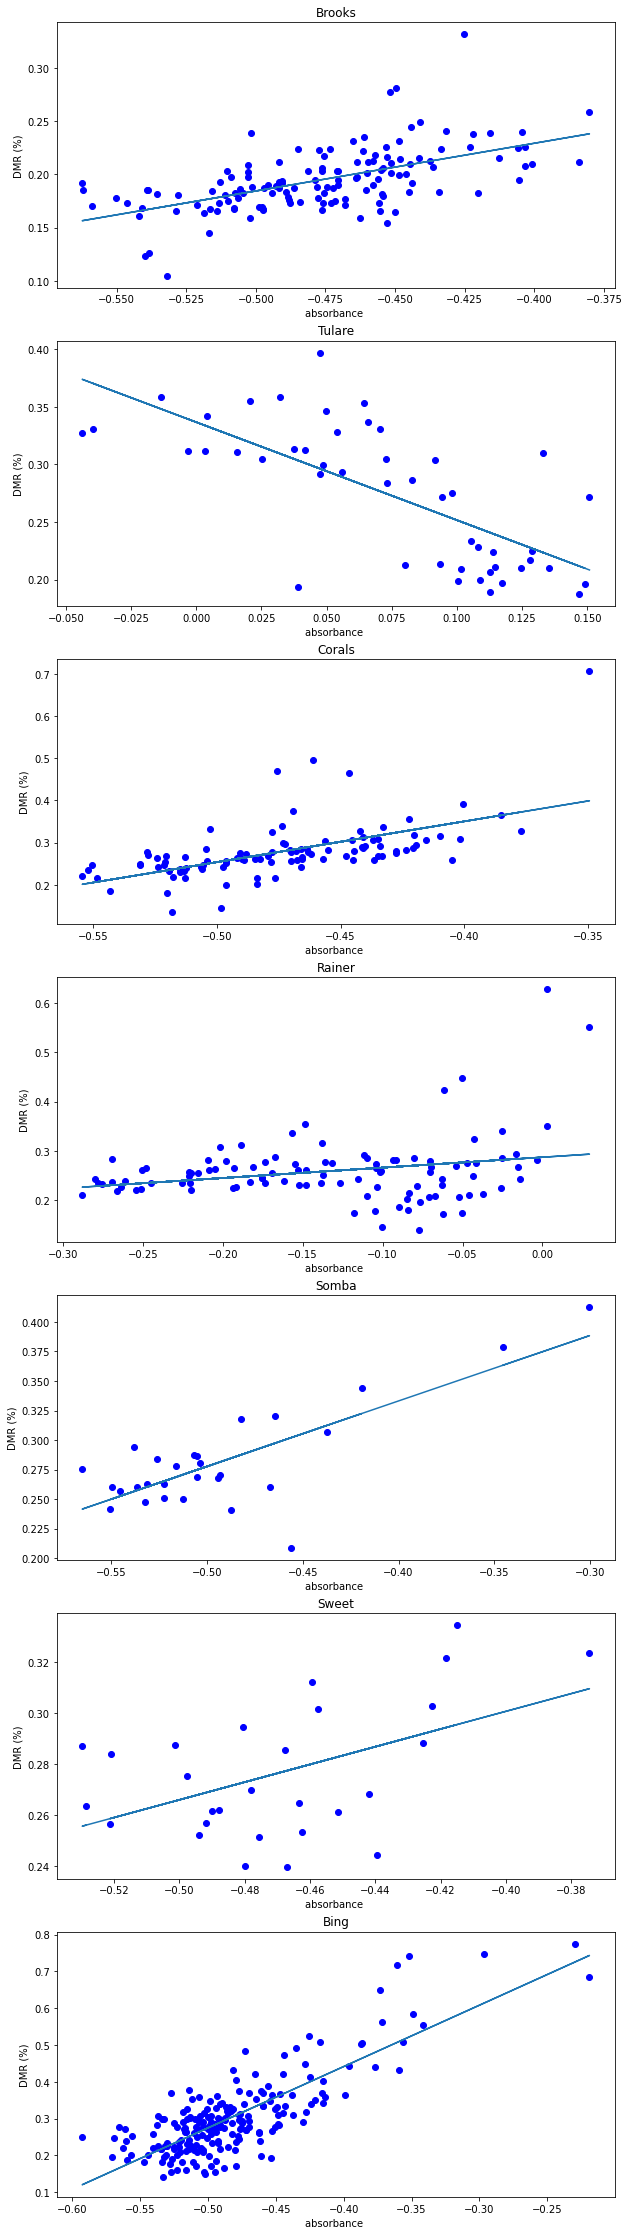

In [24]:
r_squared = [] #Creating a new list to hold our r_squared values.
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 40)) # Defining subplot properties
i = 0
for variety in varieties: 
  
  y = df_cherry_spectral[df_cherry_spectral['variety'] == variety]['dry_matter_ratio'] #Assigning our Y value as each variety's dry_matter_ratio correlation per spectra
  X = df_cherry_spectral[df_cherry_spectral['variety'] == variety][df_best_lm_spectra_minrmse.loc[df_best_lm_spectra_minrmse['variety'] == variety, 'spectra']] #Assigning -
  #- each varity's smallest RMSE value spectra, as our X variable.
  #i +=1
  #Xi = df_best_lm_spectra_minrmse.iloc[i]['spectra']
  #X.loc[:, (X.columns != 'dry_matter_ratio') & (X.columns != 'variety')]
  
  model = LinearRegression() 
  a = model.fit(X,y) 
  y_predict = a.predict(X)
  r_2 = r2_score(y, y_predict) #Using our r2_score function to calculate the explained variance within our model
  r_squared.append(r_2) 
  plt.subplot(7,1,i+1)
  i+=1
  plt.plot(X, y_predict)
  plt.scatter(X, y, color='blue', label="variety")
  plt.xlabel("absorbance ")
  plt.ylabel("DMR (%)") #Titling, labeling, and plotting our data & model for each variety.
  plt.title(variety)








df_best_lm_spectra_minrmse['r_squared'] = r_squared #Adding a new column to our dataset with the appended r_squared values.
df_best_lm_spectra_minrmse

#### Listed the varieties in order of best to worst fit based on the $R^2$ performance metric.

In [25]:
df_best_lm_spectra_minrmse = df_best_lm_spectra_minrmse.sort_values(by = ['r_squared'], ascending = False) #Listing varieties from best to worst fit based on their r squared-
#- values from their model. 
performance_model = []
performance_model.append(df_best_lm_spectra_minrmse['variety'])
df_best_lm_spectra_minrmse 
performance_model

[525     Tulare
 1208     Somba
 172     Brooks
 1749      Bing
 683     Corals
 1499     Sweet
 1050    Rainer
 Name: variety, dtype: object]